In [330]:
import pandas as pd
import pprint
from sklearn.tree import DecisionTreeClassifier
from impyute.imputation.cs import mice#
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer#
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import missingno as msno#
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform, pdist
from missingpy import KNNImputer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set()
pd.set_option("display.max_rows", 8)
plt.rcParams['figure.figsize'] = (9, 6)
from missingpy import MissForest
import io
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn import decomposition
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold

In [2]:
Dapp = pd.read_csv("horse-colic.data" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
Dtest = pd.read_csv("horse-colic.test" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
liste_drop = ["V22","V23","V24","V25","V26","V27"]
Dapp = Dapp.drop(liste_drop , axis = 1)
Dtest = Dtest.drop(liste_drop , axis = 1)
Dapp = Dapp.replace("?",np.nan)
Dtest = Dtest.replace("?",np.nan)
Dtest
Dapp
#On utilisera une méthode d'imputation qui gère différentes types de variables
#le but étant que les variables gardent la même distribution qu'auparavant
#https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
#On se doit tout de même spécifier le type des variables


In [2]:
d = {}
liste_categorical = [] ; liste_numerical = []
for i in range(22):
    if(i in list(range(3)) + list(range(6 , 15)) + [16 , 17 , 20]):
        d["V"+str(i)] = "category"
        liste_categorical.append("V"+str(i))
    else:
        d["V"+str(i)] = "float64"
        liste_numerical.append("V"+str(i))
liste_categorical
liste_numerical

['V3', 'V4', 'V5', 'V15', 'V18', 'V19', 'V21']

In [4]:
Dapp = Dapp.astype(d)
Dtest = Dtest.astype(d)
Dapp_num = Dapp.select_dtypes(include=['float64']) ; Dapp_cat = Dapp.select_dtypes(include=['category'])
Dtest_num = Dtest.select_dtypes(include=['float64']) ; Dtest_cat = Dtest.select_dtypes(include=['category'])
Dtest_cat.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat.loc[: , "V9"], categories=["1","2","3"]))
#Affectation des "bons" types pour chaque variable


C:\Users\Benco\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
def g(l): #imputation multiple sur les variables numériques
    return np.array([float(x) for x in l])

imputed_training=mice(np.array(list(map(g , Dapp_num.values))))
imputed_test = mice(np.array(list(map(g , Dtest_num.values))))

Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_training))))).round(2)
Dapp_num_imputed.columns = liste_numerical

Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_test))))).round(2)
Dtest_num_imputed.columns = liste_numerical

In [6]:
## On a généré quelques valeurs négatives, il est nécessaire d'effectuer de nouvelles imputations sur nos données
## on utilisera des imputations simples de type KNN basées sur la notion de distance
Dapp_num_imputed[Dapp_num_imputed < 0] = np.nan
Dtest_num_imputed[Dtest_num_imputed < 0] = np.nan

distances_app = pdist(Dapp_num_imputed.values, metric='euclidean')
dist_matrix_app = squareform(distances_app)
matrice_distance_app = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_app))))).round(2)

distances_test = pdist(Dtest_num_imputed.values, metric='euclidean')
dist_matrix_test = squareform(distances_test)
matrice_distance_test = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_test))))).round(2)
#on ne peut pas se permettre de prendre des poids uniformes
#en effet, il se peut que le 2e plus proche soit en réalité très loin du point par rapport au premier

C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\missingpy\utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: Deprecati

In [ ]:
imputer = KNNImputer(n_neighbors=15, weights="distance")
Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dapp_num_imputed)))))).round(2)

imputer = KNNImputer(n_neighbors=3, weights="distance")
Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dtest_num_imputed)))))).round(2)

Dapp_num_imputed.columns = liste_numerical ; Dtest_num_imputed.columns = liste_numerical
#le choix du nombre de voisins est difficile, on fait donc des choix arbitraires

In [9]:
{lab : 1-(len(Dtest_num[lab].dropna())/len(Dtest_num)) for lab in liste_numerical} 
{lab : 1-(len(Dapp_num[lab].dropna())/len(Dapp_num)) for lab in liste_numerical} 
#calcul de la proportion de données manquantes pour chaque variable numéique

{'V3': 0.19999999999999996,
 'V4': 0.07999999999999996,
 'V5': 0.19333333333333336,
 'V15': 0.8233333333333334,
 'V18': 0.09666666666666668,
 'V19': 0.10999999999999999,
 'V21': 0.6599999999999999}

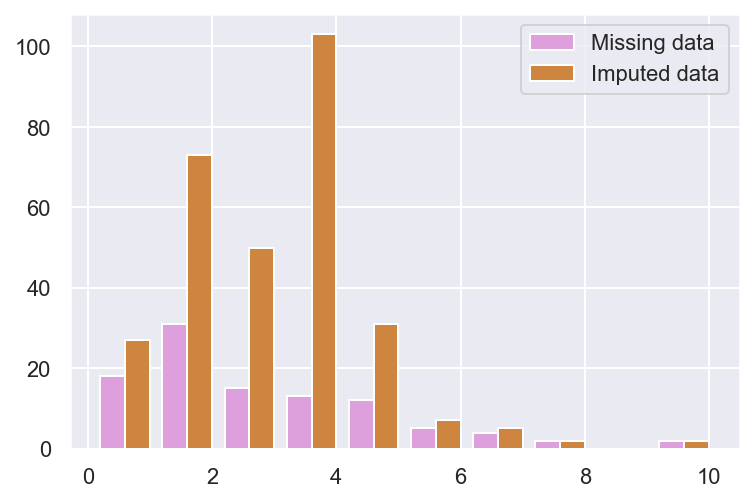

In [10]:
x = Dapp_num.V21
y = Dapp_num_imputed.V21
#L'objectif est de comparer les distributions pour voir si l'on observe une certaine cohérence après imputation
#on compare les distributions avant/après
#on calcule aussi la proportion de données manquantes pour être sûr que la comparaison ait un sens.
#il faut que le % de données manquantes ne soit ni trop faible ni trop élevé pour pouvoir comparer
#on peut faire une "évaluation" visuelle de notre imputation sur la variable choisie
plt.hist([x, y], label=['Missing data', 'Imputed data'] , color = ["plum","peru"])
plt.legend(loc='upper right')
plt.show()

In [ ]:
##La variable ID hôpital sera supprimée, qui peut être considéré (globalement) comme un identifiant pour les chevaux
##en effet, si l'on conserve cette variable en termes d'ajustement, on sera performant.
##cependant, nos algorithmes de prédiction ne seront pas bons d'un point de vue de la généralisation
#62 lignes des données de test sont des nouveaux identifiants -- > overfitting

#On peut regarder ce qui peut se passer si on décide de la conserver dans la page html Overfitting.html

#Réf : Unleash Machine Learning Techniques, De Raghav Bali, Dipanjan Sarkar, Brett Lantz p.393
#Advances in Computing and Information Technolog, Natarajan Meghanathan, Dhinaharan Nagamalai, Nabendu Chaki P.352

In [7]:
Dapp_cat = Dapp_cat.drop(["V2"] , axis = 1) ; Dtest_cat = Dtest_cat.drop(["V2"] , axis = 1)
cat_cols = [Dapp_cat.columns.get_loc(col) for col in Dapp_cat.select_dtypes(['category']).columns.tolist()]
## imputation pour les variables qualitatives à l'aide de fôrets aléatoires
imputer = MissForest(random_state = 100)
Dapp_cat_imputed = imputer.fit_transform(Dapp_cat , cat_vars = cat_cols)
Dapp_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dapp_cat_imputed)))))
Dapp_cat_imputed.columns = [x for x in liste_categorical if(x!="V2")] #if(x!="V2")
Dapp_cat_imputed = Dapp_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)

Dtest_cat_imputed = imputer.transform(Dtest_cat)
Dtest_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dtest_cat_imputed)))))
Dtest_cat_imputed.columns = [x for x in liste_categorical if(x!="V2")] #if(x!="V2")
Dtest_cat_imputed = Dtest_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)
Dtest_cat_imputed.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat_imputed.loc[: , "V9"], categories=["1","2","3"]))
#une modalité de V9 n'est pas présente dans la variable V9 des données de test : il faut rajouter une catégorie
#pour la variable V9 des données de test

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [8]:
{lab : 1-(len(Dtest_cat[lab].dropna())/len(Dtest)) for lab in liste_categorical if(lab != "V2")} 
{lab : 1-(len(Dapp_cat[lab].dropna())/len(Dapp)) for lab in liste_categorical if(lab != "V2")}
#les proportions de données manquantes pour chaque variable qualitative

{'V0': 0.0033333333333332993,
 'V1': 0.0,
 'V6': 0.18666666666666665,
 'V7': 0.22999999999999998,
 'V8': 0.15666666666666662,
 'V9': 0.10666666666666669,
 'V10': 0.18333333333333335,
 'V11': 0.1466666666666666,
 'V12': 0.18666666666666665,
 'V13': 0.3466666666666667,
 'V14': 0.3533333333333334,
 'V16': 0.33999999999999997,
 'V17': 0.3933333333333333,
 'V20': 0.55}

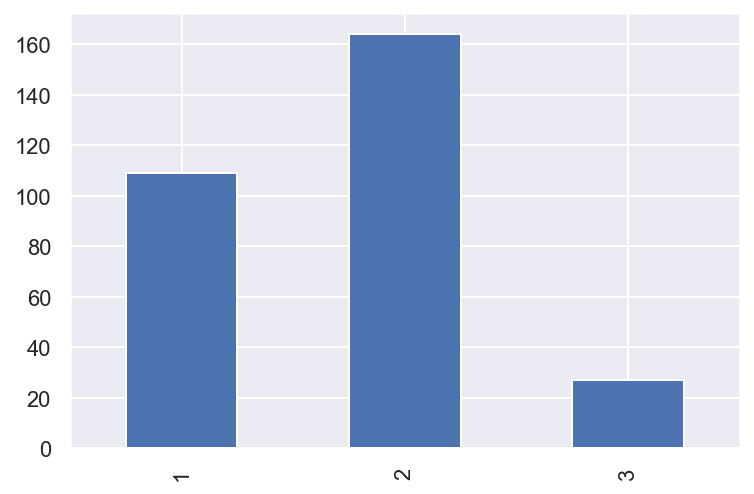

In [11]:
Dapp_cat_imputed.V13.value_counts().sort_index().plot(kind = "bar")
#en pratique, il est nécessaire de vérifier la distribution des variables avant\après imputation
#on trace donc des barplot pour avoir une idée

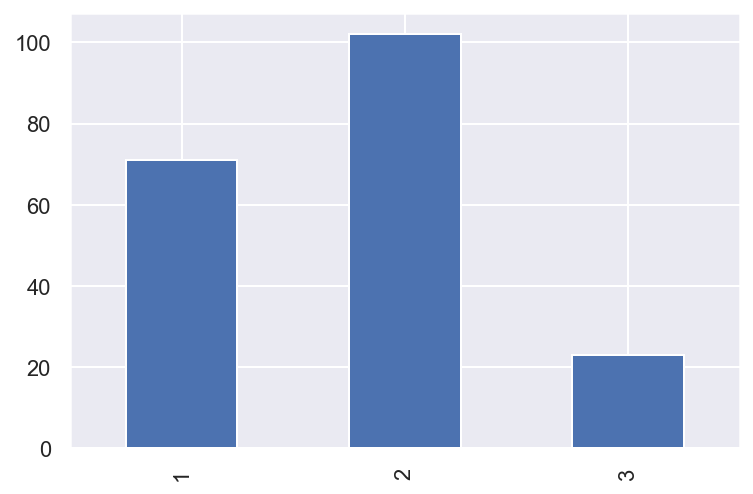

In [12]:
Dapp_cat["V13"].value_counts().sort_index().plot(kind = "bar")

In [13]:
Dapp_imputed = pd.concat([Dapp_num_imputed.reset_index(drop=True), Dapp_cat_imputed], axis=1)
Dapp_imputed.columns = [int(x[1:]) for x in Dapp_imputed.columns]
Dapp_imputed = Dapp_imputed.sort_index(axis = 1)
Dapp_imputed.columns = ["V"+str(x) for x in Dapp_imputed.columns]

Dtest_imputed = pd.concat([Dtest_num_imputed.reset_index(drop=True), Dtest_cat_imputed], axis=1)
Dtest_imputed.columns = [int(x[1:]) for x in Dtest_imputed.columns]
Dtest_imputed = Dtest_imputed.sort_index(axis = 1)
Dtest_imputed.columns = ["V"+str(x) for x in Dtest_imputed.columns]
Dtest_imputed

,V0,V1,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,2,1,38.5,54.0,20.0,3,1,2,2,3,...,1,2,2,5.90,4,2,42.0,6.3,3,4.86
1,2,1,37.6,48.0,36.0,1,1,1,1,3,...,2,1,1,5.32,3,5,44.0,6.3,1,5.00
2,1,1,37.7,44.0,28.0,3,4,3,2,5,...,4,1,1,2.52,3,5,45.0,70.0,3,2.00
3,1,1,37.0,56.0,24.0,3,1,4,2,4,...,3,1,1,1.90,3,5,35.0,61.0,3,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2,1,37.8,42.0,40.0,1,1,1,1,1,...,1,2,1,7.01,3,3,36.0,6.2,1,3.32
65,1,1,38.0,60.0,12.0,1,1,2,1,2,...,1,1,1,2.34,1,4,44.0,65.0,3,2.00
66,2,1,38.0,42.0,12.0,3,1,3,1,1,...,1,2,1,6.20,1,1,37.0,5.8,1,2.89
67,2,1,37.6,88.0,36.0,3,1,1,1,3,...,2,1,3,1.50,4,4,44.0,6.0,2,10.80


In [14]:
Dapp_imputed

,V0,V1,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,2,1,38.5,66.0,28.0,3,3,4,2,5,...,4,2,1,5.65,3,5,45.0,8.40,3,3.48
1,1,1,39.2,88.0,20.0,3,3,4,1,3,...,2,2,1,1.52,4,2,50.0,85.00,2,2.00
2,2,1,38.3,40.0,24.0,1,1,3,1,3,...,1,1,1,5.97,1,1,33.0,6.70,1,3.22
3,1,9,39.1,164.0,84.0,4,1,6,2,2,...,4,1,2,5.00,3,5,48.0,7.20,3,5.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,2,1,37.2,72.0,24.0,3,2,4,2,4,...,3,3,1,4.12,4,4,44.0,22.55,3,3.30
297,1,1,37.5,72.0,30.0,4,3,4,1,4,...,3,2,1,5.74,3,5,60.0,6.80,2,3.74
298,1,1,36.5,100.0,24.0,3,3,3,1,3,...,3,3,1,3.29,4,4,50.0,6.00,3,3.40
299,1,1,37.2,40.0,20.0,1,1,1,1,3,...,1,2,1,1.93,4,1,36.0,62.00,1,1.00


In [ ]:
#n'exécutez pas la cellule suivante: l'idée était de présenter notre démarche
#Pour la partie modèlisation/performance, on va se baser sur un autre jeu de données provenant de pickle

In [15]:
#Dtest_imputed.to_pickle("Dtest_imputed.pkl") 
#Dapp_imputed.to_pickle("Dapp_imputed.pkl")

In [3]:
Dapp_imputed = pd.read_pickle("Dapp_imputed.pkl")
Dtest_imputed = pd.read_pickle("Dtest_imputed.pkl")

In [4]:
liste_cat_bis = [x for x in liste_categorical if(x not in ["V0" , "V2"] )]

In [5]:
scaler = StandardScaler()
#Au-delà du scaling, on décide de supprimer la 1ère modalité de chaque variable, on évite avec cela de la redondance
#dans nos variables --> multicolinéarité (notamment problématique dans le cadre d'une régression logistique)
Dapp_imputed[liste_numerical] = scaler.fit_transform(Dapp_imputed[liste_numerical])
Dapp_imputed["V0"] = pd.Series([1 if(x=="1") else 0 for x in Dapp_imputed["V0"]])
Dapp_imputed = Dapp_imputed.astype({"V0" : "int32"})
Dapp_imputed = pd.get_dummies(Dapp_imputed , columns = liste_cat_bis , drop_first = True)

Dtest_imputed[liste_numerical] = scaler.transform(Dtest_imputed[liste_numerical])
Dtest_imputed["V0"] = pd.Series([1 if(x=="1") else 0 for x in Dtest_imputed["V0"]])
Dtest_imputed = Dtest_imputed.astype({"V0" : "int32"})
Dtest_imputed = pd.get_dummies(Dtest_imputed , columns = liste_cat_bis , drop_first = True)

Dapp_imputed
Dtest_imputed

,V0,V3,V4,V5,V15,V18,V19,V21,V1_9,V6_2,...,V14_3,V16_2,V16_3,V16_4,V17_2,V17_3,V17_4,V17_5,V20_2,V20_3
0,0,0.500243,-0.650492,-0.654538,0.697801,-0.429803,-0.698636,1.310827,0,0,...,0,0,0,1,1,0,0,0,0,1
1,0,-0.869175,-0.867153,0.339489,0.393306,-0.228614,-0.698636,1.408744,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,-0.717017,-1.011594,-0.157524,-1.076670,-0.128020,1.760598,-0.689474,0,0,...,0,0,1,0,0,0,0,1,0,1
3,1,-1.782120,-0.578272,-0.406031,-1.402164,-1.133963,1.413140,-0.689474,0,0,...,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,-0.564860,-1.083814,0.587996,1.280541,-1.033369,-0.702497,0.233741,0,0,...,0,0,1,0,0,1,0,0,0,0
65,1,-0.260544,-0.433832,-1.151551,-1.171168,-0.228614,1.567566,-0.689474,0,0,...,0,0,0,0,0,0,1,0,0,1
66,0,-0.260544,-1.083814,-1.151551,0.855298,-0.932774,-0.717939,-0.067003,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,-0.869175,0.577252,0.339489,-1.612161,-0.228614,-0.710218,5.465298,0,0,...,1,0,0,1,0,0,1,0,1,0


In [6]:
X_train = Dapp_imputed.drop(["V0"] , axis = 1) ; Y_train = Dapp_imputed["V0"]
X_test = Dtest_imputed.drop(["V0"] , axis = 1) ; Y_test = Dtest_imputed["V0"]
#Voici nos jeux de données d'entrainement ainsi que de tests
X_train

In [ ]:
##En pratique, pour calibrer les paramètres de chaque méthode, on devrait utiliser une validation croisée LOOCV
#car notre jeu de données est relativement petit
#cependant cela est coûteux en termes de temps, on fera donc pour certaines méthode des validations croisées 3-fold

In [20]:
np.linalg.det(np.dot(np.transpose(X_train) , X_train)) #la matrice de design est bien de rang plein
#cependant, on ne pourra pas vérifier la séparabilité linéaire des données selon le label
#cela nous aurait garanti la convergence vers un minimum global dans le cadre d'une régression logistique

5.21818224395592e+66

In [331]:
def param_selection_log(X, y,Cs):
    logreg = LogisticRegression(penalty = "l2", solver = "lbfgs" , max_iter = 5000 , tol = 1e-6)
    parameters = {'C':Cs}
    clf = GridSearchCV(logreg, parameters, cv = KFold(n_splits = 300))
    clf.fit(X_train, Y_train)
    return clf.best_params_

In [ ]:
%%time
C_log = param_selection_log(X_train, Y_train , [.001 , 0.01 , 0.1 , 1 , 10 , 100])["C"]
logreg = LogisticRegression(penalty = "l2", solver = "lbfgs" , max_iter = 5000 , tol = 1e-6 , C = C_log)
logreg.fit(X_train , Y_train)
y_pred = logreg.predict(X_test)
y_fit = logreg.predict(X_train)
accuracy_score(y_pred, Y_test) #1 minute

In [9]:
C_log

1

In [10]:
accuracy_score(y_fit, Y_train)


0.82

In [11]:
Y_train = pd.Series([-1 if(y==0) else 1 for y in Y_train])
Y_test = pd.Series([-1 if(y==0) else 1 for y in Y_test])

Text(0, 0.5, 'Second Principal Component')

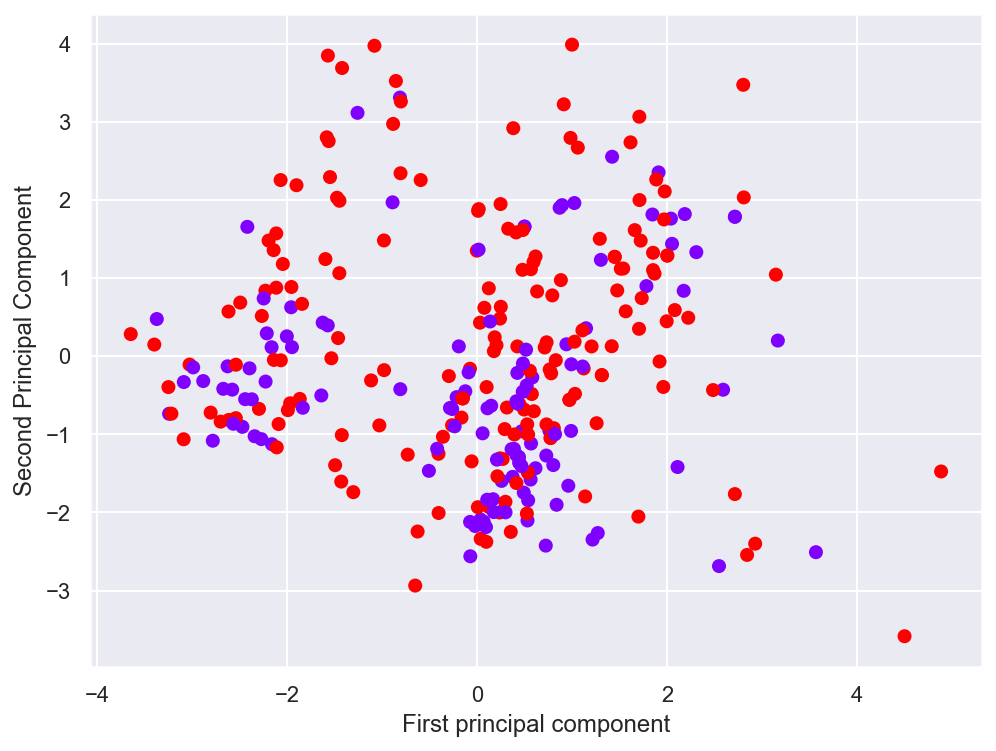

In [93]:
#Faisons une ACP pour avoir une intuition sur la séparabilité linéaire des données
pca = decomposition.PCA(n_components=3)
pca.fit(X_train)
X = pca.transform(X_train)
plt.figure(figsize=(8,6))
plt.scatter(X[:,0] , X[:,1] ,c=Y_train,cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

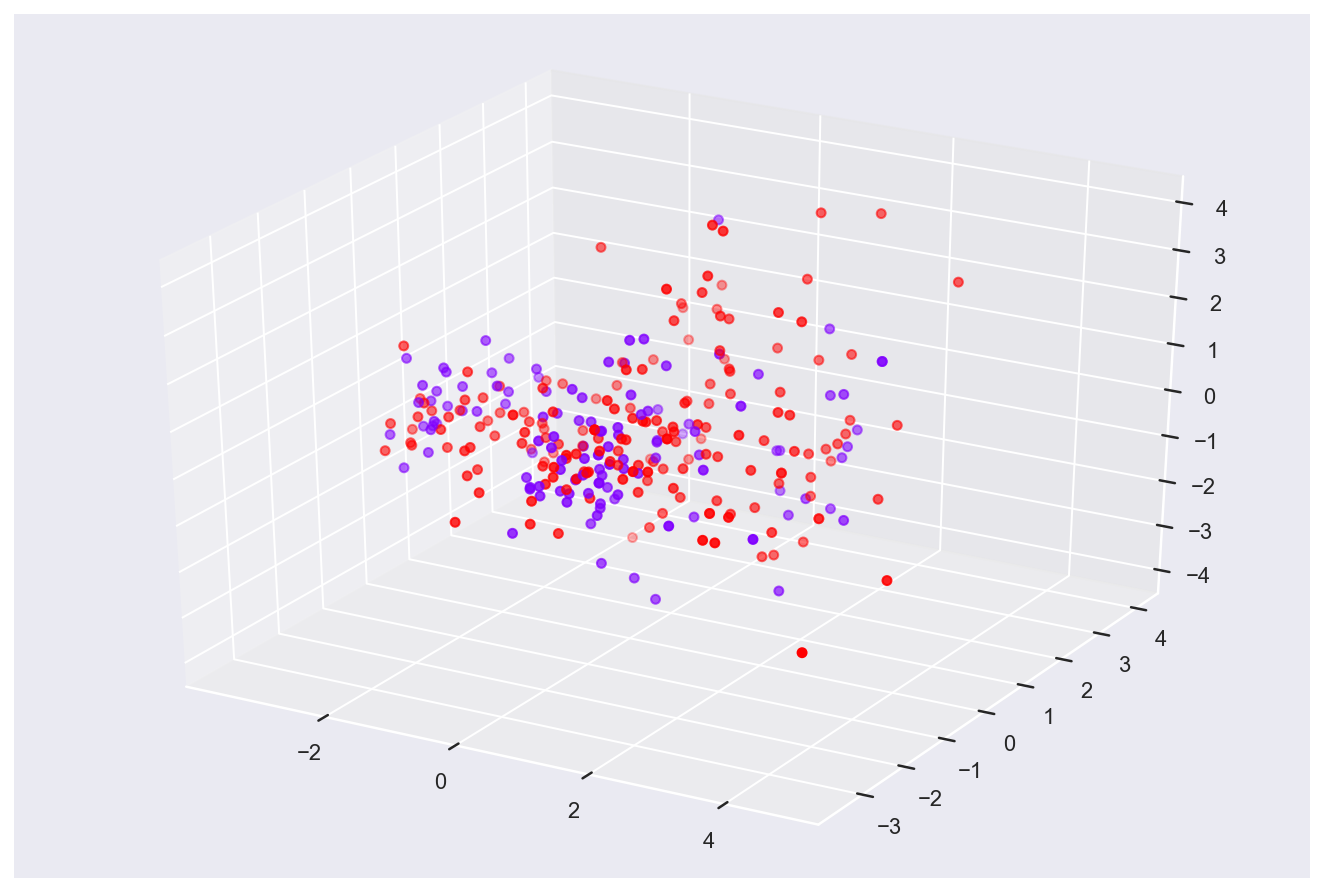

In [404]:
#3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(X[:,0], X[:,1], X[:,2], c=Y_train , cmap = "rainbow")
## ce ne sont que des outils de visualisation et au vue de notre score sur les Dapp, on pourrait penser que les donnéees
#ne sont pas linéairement séparables (on utilise un classifieur linéaire) -- > information très importante
## il y a de fortes chances que l'algorithme itératif de la régression logistique n'ait atteint qu'un minimum
#local

In [13]:
%%time
#40 secondes
def svc_param_selection_lin(X, y,Cs):
    Cs = list(np.unique([round(x,3) for x in Cs]))
    parameters = {'kernel':['linear'], 'C':Cs}
    svc = svm.SVC(gamma = 1 , coef0 = 0)
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = KFold(n_splits = 300))
    clf.fit(X_train, Y_train)
    return clf.best_params_

C_lin = svc_param_selection_lin(X_train, Y_train , [0.01 , 0.1 , 1 , 10])["C"]
#Naturellement, on se dirigera vers les SVM non linéaires de manière à déterminer un hyperplan dans un espace 
#de plus grande dimension

clf = LinearSVC(C = C_lin , max_iter = 100000)
clf.fit(X_train , Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)

#on constate donc que les performances sont similaires, on aura beau augmenté la constante de tolérance cela
#ne fera pas augmenter le taux de bon classés dans les données d'apprentissage au contraire ...
#on insiste bien sur l'erreur d'ajustement car c'est un moyen de juger la non-séparabilité 
#avec les données de départ, il semble difficile de déterminer un hyperplan comme en régression logistique
#on décide donc d'opter pour les SVM à noyaux

Wall time: 56.4 s


0.7058823529411765

In [40]:
accuracy_score(y_fit, Y_train)

0.82

In [14]:
%%time
#maximum 2 minute, on utilise lorsque c'est possible LOOCV, en général on prendra un degré égal à 2
#ce qui conduit à un sur-ajustement sur ce jeu de données imputé
def svc_param_selection_poly(X, y,Cs , degree):
    Cs = list(np.unique([round(x,3) for x in Cs]))
    parameters = {'kernel':['poly'], 'C':Cs , "degree" : degree}
    svc = svm.SVC(gamma = 1)
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = KFold(n_splits = 300))
    clf.fit(X_train, Y_train)
    return clf.best_params_
params_poly = svc_param_selection_poly(X_train, Y_train , [0.01 , 0.1 , 1 , 10] , list(range(1,4)))
ksvm_poly = svm.SVC(kernel="poly", degree = params_poly["degree"] , C = params_poly["C"] , gamma = 1)               
ksvm_poly.fit(X_train, Y_train)
y_pred = ksvm_poly.predict(X_test)
y_fit = ksvm_poly.predict(X_train)
accuracy_score(y_pred, Y_test)
## sur la base de nos grilles choisies, le meilleur score obtenu provient d'une SVM linéaire classique
## on décide de ne pas optimiser la constante du polynôme
## les résultats sont différents de la SVM utilisée au préalable (peut-être à cause d'une implémentation différente)

Wall time: 2min 1s


0.6176470588235294

In [15]:
params_poly 

{'C': 0.01, 'degree': 2, 'kernel': 'poly'}

In [16]:
accuracy_score(y_fit, Y_train) #sur-ajustement avec ce modèle --> degré élevé avec 2

0.9066666666666666

In [317]:
%%time
def svc_param_selection(X, y,Cs,Gs): #on se limite à une VC 3-fold car moins coûteuse
    Cs = list(np.unique([round(x,3) for x in Cs]))
    parameters = {'C': Cs, 'gamma': Gs, 'kernel': ['rbf']}
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = KFold(n_splits = 3))
    clf.fit(X_train, Y_train)
    return clf.best_params_

params = svc_param_selection(X_train, Y_train , [0.01 , 0.1 , 1 , 10 , 100] , [0.0001 , 0.001 , 0.1 , 1 , 10])

ksvm = svm.SVC(kernel="rbf", gamma = params["gamma"] , C = params["C"])               
ksvm.fit(X_train, Y_train)
y_pred = ksvm.predict(X_test)
y_fit = ksvm.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)
#le choix de gamma peut s'avérer très compliqué, il en est de même pour le choix du noyau ainsi que de la tolérance,
#on se limite donc à chercher une constante de tolérance optimal pour un noyau RBF
#on pourrait vérifier que si C est grand alors le taux de classification est égal à 1
#on voit aussi que les performances sur les données de test sont moins bonnes

Wall time: 1.6 s


0.6176470588235294

In [318]:
params

{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}

In [57]:
accuracy_score(y_fit, Y_train) #sur-ajustement possible

0.8966666666666666

In [249]:
def oob_m(liste): #renvoie le m minimisant l'erreur OOB
    l = []
    for m in liste:
        clf = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = m , min_samples_split = 2,
                            oob_score = True)
        clf.fit(X_train, Y_train)
        l.append((m , clf.oob_score_))
    return min(l , key = lambda x : x[1])[0]

m = oob_m(range(1,8))

In [250]:
clf = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = m , min_samples_split = 2,
                            oob_score = True)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)
#accuracy_score(y_fit, Y_train)

#dans notre cas de figure, déterminer m à l'aide de l'erreur OOB peut être une source de sur-apprentissage
#on optera pour une validation croisée pour déterminer m
#l'overfitting, provient de la profondeur des arbres, on veut qu'il soit profond car des arbres profonds ont
#un biais faible, c'est l'un des principes des fôrets

0.6911764705882353

In [251]:
accuracy_score(y_fit, Y_train) #idem, on ne peut pas utiliser ce modèle

1.0

In [52]:
def rfc_CV(ms):
    rfc = RandomForestClassifier(random_state = 0, min_samples_split = 2,
                            oob_score = True , n_estimators = 100)
    param_grid = {'max_features': ms}
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= KFold(n_splits = 3))
    CV_rfc.fit(X_train, Y_train)
    return CV_rfc.best_params_["max_features"]
#on décide de faire une 5-fold car la LOO est coûteuse

In [54]:
%%time
ms = list(range(1,6))
m = rfc_CV(ms)
rfc = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = m , min_samples_split = 2,
                            oob_score = True)
rfc.fit(X_train, Y_train)
y_pred = rfc.predict(X_test)
y_fit = rfc.predict(X_train)
accuracy_score(y_pred, Y_test)

Wall time: 3.12 s


0.7352941176470589

In [55]:
accuracy_score(y_fit, Y_train) #il semblerait que les arbres profonds ont une forte variance
#à cause de la variance des arbres profonds, on considérera que cette méthode n'est pas adaptée à notre
#problème supervisé car le but est d'avoir des arbres profonds (ces arbres ont un biais faible).
#Le but 

1.0

In [56]:
def knn_CV(ks):
    neigh = KNeighborsClassifier()
    param_grid = {'n_neighbors': ks}
    CV_knn = GridSearchCV(estimator=neigh, param_grid=param_grid, cv= KFold(n_splits = 300))
    CV_knn.fit(X_train, Y_train)
    return CV_knn.best_params_["n_neighbors"]


In [57]:
%%time
k = knn_CV(list(range(2,20)))

Wall time: 43.8 s


In [58]:
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, Y_train)
y_pred = neigh.predict(X_test)
y_fit = neigh.predict(X_train)
accuracy_score(y_pred, Y_test)

0.5882352941176471

In [61]:
k

3

In [60]:
accuracy_score(y_fit , Y_train) #performanc faible mais le sur-ajustement semble moins important
##cette performance nous permet de comprendre que la dimension est déjà "assez" importante

0.84

In [252]:
pca = decomposition.PCA()
knn = KNeighborsClassifier()
pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])
n_components = [6, 8, 10]
params_grid = [{
'knn__n_neighbors': list(range(1,11)),
'pca__n_components': n_components,
}]

In [253]:
grd = GridSearchCV(pipe, param_grid = params_grid)
grd.fit(X_train , Y_train)
accuracy_score(grd.predict(X_test) , Y_test)
## la performance reste faible malgré la réduction de la dimension

C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6323529411764706

In [255]:
grd.best_params_

{'knn__n_neighbors': 3, 'pca__n_components': 10}

In [254]:
accuracy_score(Y_train , grd.predict(X_train))

0.84

In [216]:
def ada_CV(ns ,ls):
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1) , random_state=0)
    param_grid = {'n_estimators': ns , "learning_rate" : ls}
    CV_ada = GridSearchCV(estimator=ada, param_grid=param_grid, cv= KFold(n_splits = 3))
    CV_ada.fit(X_train, Y_train)
    return CV_ada.best_params_

In [217]:
%%time
params = ada_CV(list(range(1,20)) , np.linspace(0.01 , 0.6 , 10))

Wall time: 18.5 s


In [218]:
params

{'learning_rate': 0.4033333333333333, 'n_estimators': 18}

In [220]:
ada = AdaBoostClassifier(n_estimators = params["n_estimators"] ,
                         learning_rate = params["learning_rate"],
                         random_state=0)
ada.fit(X_train, Y_train)
y_pred = ada.predict(X_test)
y_fit = ada.predict(X_train)
accuracy_score(y_pred, Y_test)


0.6911764705882353

In [221]:
(accuracy_score(y_fit, Y_train)) #paramètres difficiles à calibrer, on n'utilisera pas ce modèle car lègerement moins 
#performant que la svm linéaire et l'ajustement n'est pas "bon".


0.7833333333333333

In [210]:
def dtree_grid_search(X,y,depth):
    param_grid = {'max_depth': depth}
    dtree_model=DecisionTreeClassifier(random_state = 0)
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv= KFold(n_splits = 3))
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

0.6911764705882353

In [ ]:
P = dtree_grid_search(X_train,Y_train,list(range(3,20)))["max_depth"]
arb = DecisionTreeClassifier(random_state=0 , max_depth = P)
arb.fit(X_train, Y_train)
y_pred = arb.predict(X_test)
y_fit = arb.predict(X_train)
accuracy_score(y_pred, Y_test)

In [92]:
P

3

In [211]:
accuracy_score(y_fit, Y_train) #sous-apprentissage

0.78